##Generating names with recurrent neural networks

This time you'll find yourself delving into the heart (and other intestines) of recurrent neural networks on a class of toy problems.

Struggle to find a name for the variable? Let's see how you'll come up with a name for your son/daughter. Surely no human has expertize over what is a good child name, so let us train RNN instead



In [84]:
import tensorflow as tf
print(tf.__version__)
import numpy as np
import pandas as pd
import keras
import matplotlib.pyplot as plt
%matplotlib inline

1.13.1


##Load data

The dataset contains ~8k earthling names from different cultures, all in latin transcript.

This notebook has been designed so as to allow you to quickly swap names for something similar: deep learning article titles, IKEA furniture, pokemon names, etc.


In [0]:

start_token=" "
# so that the network knows that we're generating a first token
# this is the token for padding,
# we will add fake pad token at the end of names 
# to make them of equal size for further batching
pad_token="#"
with open("names") as f:
  names=f.read()[:-1].split("\n")
  names=[start_token+name for name in names]

In [88]:
print("number of samples: ", len(names))
for x in names[::1000]:
  print(x)

number of samples:  7944
 Abagael
 Claresta
 Glory
 Liliane
 Prissie
 Geeta
 Giovanne
 Piggy


max length 16


(array([1.900e+01, 2.720e+02, 0.000e+00, 9.260e+02, 0.000e+00, 1.878e+03,
        0.000e+00, 2.049e+03, 0.000e+00, 1.447e+03, 0.000e+00, 8.460e+02,
        0.000e+00, 3.510e+02, 0.000e+00, 1.160e+02, 0.000e+00, 2.400e+01,
        0.000e+00, 1.000e+01, 0.000e+00, 3.000e+00, 0.000e+00, 1.000e+00,
        2.000e+00]),
 array([ 3.  ,  3.52,  4.04,  4.56,  5.08,  5.6 ,  6.12,  6.64,  7.16,
         7.68,  8.2 ,  8.72,  9.24,  9.76, 10.28, 10.8 , 11.32, 11.84,
        12.36, 12.88, 13.4 , 13.92, 14.44, 14.96, 15.48, 16.  ]),
 <a list of 25 Patch objects>)

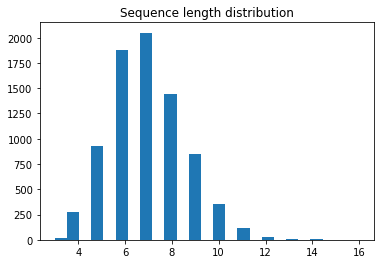

In [89]:
MAX_LENGTH=max(map(len,names))
print("max length", MAX_LENGTH)

plt.title("Sequence length distribution")
plt.hist(list(map(len,names)),bins=25)

##Text processing

First we need to collect a "vocabulary" of all unique tokens i.e. unique characters. We can then encode inputs as a sequence of character ids.


In [90]:
tokens=set(" ".join(names[:]))

tokens=list(tokens)
n_tokens=len(tokens)
print("n_tokens: ",n_tokens)


n_tokens:  55


##Cast everything from symbols into identifiers

Tensorflow string manipulation is a bit tricky, so we'll work around it. We'll feed our recurrent neural network with ids of characters from our dictionary.

To create such dictionary, let's assign token_to_id


In [0]:
token_to_id={}
for i in range(n_tokens):
  token_to_id[tokens[i]]=i

In [0]:
def to_matrix(names, max_len=None, pad=0, dtype=np.int32):
    """Casts a list of names into rnn-digestable padded matrix"""
    
    max_len = max_len or max(map(len, names))
    names_ix = np.zeros([len(names), max_len], dtype) + pad

    for i in range(len(names)):
        name_ix = list(map(token_to_id.get, names[i]))
        names_ix[i, :len(name_ix)] = name_ix

    return names_ix

In [72]:
# Example: cast 4 random names to padded matrices (so that we can easily batch them)
print('\n'.join(names[::2000]))
print(to_matrix(names[::2000]))

 Abagael
 Glory
 Prissie
 Giovanne
[[39 25 27 16 40 16 20 31  0]
 [39 15 31 34 47 38  0  0  0]
 [39 10 47 21  1  1 21 20  0]
 [39 15 21 34 17 16  5  5 20]]


##Defining a recurrent neural network

We can rewrite recurrent neural network as a consecutive application of dense layer to input xtxt and previous rnn state htht. This is exactly what we're gonna do now. 

Since we're training a language model, there should also be:
1. An embedding layer that converts character id x_t to a vector.
2. An output layer that predicts probabilities of next phoneme based on h_t+1
<img src="./rnn.png" width=600>

In [0]:
#reset session if you change your graph!
from keras import backend as K
def reset_tf_session():
    curr_session = tf.get_default_session()
    # close current session
    if curr_session is not None:
        curr_session.close()
    # reset graph
    K.clear_session()
    # create new session
    config = tf.ConfigProto()
    config.gpu_options.allow_growth = True
    s = tf.InteractiveSession(config=config)
    K.set_session(s)
    return s
s= reset_tf_session()

In [0]:
import keras
from keras.layers import concatenate, Dense, Embedding

rnn_num_units = 64  # size of hidden state
embedding_size = 16  # for characters

# Create layers for our recurrent network
# Create layers but don't "apply" them yet (this is a "functional API" of Keras)
# Note: set the correct activation (from keras.activations) to Dense layers!

# an embedding layer that converts character ids into embeddings
embed_x = Embedding(n_tokens, embedding_size)

# a dense layer that maps input and previous state to new hidden state, [x_t,h_t]->h_t+1
get_h_next = Dense(rnn_num_units, activation="relu")

# a dense layer that maps current hidden state to probabilities of characters [h_t+1]->P(x_t+1|h_t+1)
get_probas =  Dense(n_tokens, activation="softmax")

We will generate names character by character starting with start_token:

<img src="./char-nn.png" width=600>

In [0]:
def rnn_one_step(x_t, h_t):
    """
    Recurrent neural network step that produces 
    probabilities for next token x_t+1 and next state h_t+1
    given current input x_t and previous state h_t.
    We'll call this method repeatedly to produce the whole sequence.
    """
    # convert character id into embedding
    x_t_emb = embed_x(tf.reshape(x_t, [-1, 1]))[:, 0]
    
    # concatenate x_t embedding and previous h_t state
    x_and_h = tf.concat([x_t_emb, h_t], 1) 
    # compute next state given x_and_h
    h_next =get_h_next(x_and_h)
    
    # get probabilities for language model P(x_next|h_next)
    output_probas =get_probas(h_next) 
    
    return output_probas, h_next

##RNN: loop

Once rnn_one_step is ready, apply it in a loop over name characters to get predictions.

assume that all names are at most length-16 for now, so simply iterate over them in a for loop

In [0]:
input_sequence = tf.placeholder(tf.int32, (None, MAX_LENGTH))  
# batch of token ids
batch_size = tf.shape(input_sequence)[0]

predicted_probas = []
h_prev = tf.zeros([batch_size, rnn_num_units])  # initial hidden state

for t in range(MAX_LENGTH):
    x_t = input_sequence[:, t]  # column t
    probas_next, h_next = rnn_one_step(x_t, h_prev)
    
    h_prev = h_next
    predicted_probas.append(probas_next)
    
# combine predicted_probas into [batch, time, n_tokens] tensor
predicted_probas = tf.transpose(tf.stack(predicted_probas), [1, 0, 2])

# next to last token prediction is not needed
predicted_probas = predicted_probas[:, :-1, :]

##RNN: loss and gradients

Gather a matrix of predictions for P(xnext|h)P(xnext|h) and the corresponding correct answers.

flatten matrices to shape [None, n_tokens] to make it easier.

network can then be trained by minimizing crossentropy between predicted probabilities and those answers.


In [0]:
#flatten predictions 
predictions_matrix=tf.reshape(predicted_probas,[-1,n_tokens])
answers_matrix=tf.one_hot(tf.reshape(input_sequence[:,1:],[-1]),n_tokens)

Usually it's a good idea to ignore gradients of loss for padding token predictions.

Because we don't care about further prediction after the pad_token is predicted for the first time, so it doesn't make sense to punish our network after the pad_token is predicted.



In [0]:
# Define the loss as categorical cross-entropy (e.g. from keras.losses).
# Mind that predictions are probabilities and NOT logits!
# Apply tf.reduce_mean to get a scalar loss!
from keras.objectives import categorical_crossentropy
loss = tf.reduce_mean(categorical_crossentropy(answers_matrix, predictions_matrix))### YOUR CODE HERE

optimize = tf.train.AdamOptimizer().minimize(loss)

##RNN: training

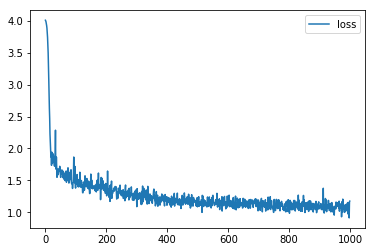

In [79]:
from IPython.display import clear_output
from random import sample

s.run(tf.global_variables_initializer())

batch_size = 32
history = []

for i in range(1000):
    batch = to_matrix(sample(names, batch_size), max_len=MAX_LENGTH)
    loss_i, _ = s.run([loss, optimize], {input_sequence: batch})
    
    history.append(loss_i)
    
    if (i + 1) % 100 == 0:
        clear_output(True)
        plt.plot(history, label='loss')
        plt.legend()
        plt.show()

##RNN: sampling

Once we've trained our network a bit, let's get to actually generating stuff. All we need is the rnn_one_step function you have written above.


In [0]:
x_t = tf.placeholder(tf.int32, (1,))
h_t = tf.Variable(np.zeros([1, rnn_num_units], np.float32))  # we will update hidden state in this variable

# For sampling we need to define `rnn_one_step` tensors only once in our graph.
# We reuse all parameters thanks to functional API usage.
# Then we can feed appropriate tensor values using feed_dict in a loop.
# Note how different it is from training stage, where we had to unroll the whole sequence for backprop.
next_probs, next_h = rnn_one_step(x_t, h_t)

In [0]:
def generate_sample(seed_phrase=start_token, max_length=MAX_LENGTH):
    '''
    This function generates text given a `seed_phrase` as a seed.
    Remember to include start_token in seed phrase!
    Parameter `max_length` is used to set the number of characters in prediction.
    '''
    x_sequence = [token_to_id[token] for token in seed_phrase]
    s.run(tf.assign(h_t, h_t.initial_value))
    
    # feed the seed phrase, if any
    for ix in x_sequence[:-1]:
         s.run(tf.assign(h_t, next_h), {x_t: [ix]})
    
    # start generating
    for _ in range(max_length-len(seed_phrase)):
        x_probs,_ = s.run([next_probs, tf.assign(h_t, next_h)], {x_t: [x_sequence[-1]]})
        x_sequence.append(np.random.choice(n_tokens, p=x_probs[0]))
        
    return ''.join([tokens[ix] for ix in x_sequence if tokens[ix] != pad_token])

In [82]:
# without prefix
for _ in range(10):
    print(generate_sample())

 TattyMMMMMMMMMM
 NenneadMMMMMMMM
 WreeMMMMMMMMMMM
 CbilyeMMMMMMMMM
 BalieMMMMMMMMMM
 SintMMMMMMMMMMM
 MagdienMMMMMMMM
 HiolaleMMMMMMMM
 TettaMMMMMMMMMM
 CoryMMMMMMMMMMM


In [83]:
# with prefix conditioning
for _ in range(10):
    print(generate_sample(' Trump'))

 TrumptieMMMMMMM
 TrumpMMMMMMMMMM
 TrumpekeMMMMMMM
 TrumpeaMMMMMMMM
 TrumperMMMMMMMM
 TrumpeMMMMMMMMM
 TrumpesMMMMMMMM
 TrumpaoMMMMMMMM
 TrumpoMMMMMMMMM
 TrumpanMMMMMMMM
